# Práctica Minería de Datos

**Este documento contiene la parte práctica de la tarea de evaluación del módulo de Minería de Datos.** 

**La idea es que vayas avanzando en el documento y completando códigos (asegurando ejecutar para que se vean las salidas) y preguntas asociadas.**

**Una vez terminado, lo guardas con el nombre "PracticaMineria_NombreApellido.ipynb" para adjuntarlo a la entrega.** 

**A disfrutar del proceso!**

## Pregunta 1

Indica en el siguiente chunk el código necesario para importar el conjunto de datos **"FEV_data.csv"** y muestra la información del archivo. 

Información sobre el archivo aquí: 
https://view.officeapps.live.com/op/view.aspx?src=http%3A%2F%2Fwww.emersonstatistics.com%2Fdatasets%2Ffev.doc&wdOrigin=BROWSELINK

In [1]:
#Importacion de librerias
import pandas as pd
from pandas.plotting import autocorrelation_plot

import numpy as np

import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram

import NuestrasFunciones as nf

import plotly.express as px

from statsmodels.formula.api import ols 
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.holtwinters as ets

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.neighbors import NearestCentroid
from sklearn import metrics
from sklearn import decomposition as dc

import seaborn as sns

import matplotlib.pyplot as plt

import pmdarima as pm

import feature_engine.imputation as fe_imp

from time import time

from pca import pca


In [2]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Lectura del archivo
fev = pd.read_csv('Datos/FEV_data.csv')
fev.head()

# Información
fev.info()
fev.nunique()
fev.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   seqnbr  654 non-null    int64  
 1   subjid  654 non-null    int64  
 2   age     654 non-null    int64  
 3   fev     654 non-null    float64
 4   height  654 non-null    float64
 5   sex     654 non-null    int64  
 6   smoke   654 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 35.9 KB


seqnbr        subjid         age         fev      height  \
count  654.00000    654.000000  654.000000  654.000000  654.000000   
mean   327.50000  37169.571865    9.931193    2.636780   61.143578   
std    188.93782  23690.860350    2.953935    0.867059    5.703513   
min      1.00000    201.000000    3.000000    0.791000   46.000000   
25%    164.25000  15811.000000    8.000000    1.981000   57.000000   
50%    327.50000  36071.000000   10.000000    2.547500   61.500000   
75%    490.75000  53638.500000   12.000000    3.118500   65.500000   
max    654.00000  90001.000000   19.000000    5.793000   74.000000   

              sex       smoke  
count  654.000000  654.000000  
mean     1.486239    1.900612  
std      0.500193    0.299412  
min      1.000000    1.000000  
25%      1.000000    2.000000  
50%      1.000000    2.000000  
75%      2.000000    2.000000  
max      2.000000    2.000000

¿Cuantos registros y variables tiene el archivo? ¿Tienen las variables el tipo correcto en relación a su lógica naturaleza?

**Respuesta**:
El archivo tiene 654 registros y 7 variables.

Las variables tienen el tipo correcto. Las posibles duda que podrian asaltar serian con 'seqnbr' y 'subjid' toman 654 valores unicos como indica el enunciado asi como con 'sex' y 'smoke' que toman 2 posibles valores al ser categoricas representando los valores de hombre y mujer (1 male, 2 female), y booleanos cierto y falso (1 o 2) respectivamente.

## Pregunta 2

Sabiendo que la variable objetivo es *Fev*. Presenta un gráfico con las relaciones de asociación de los predictores frente a Fev. 

In [3]:
# Creamos las variables de control
fev['aleatorio'] = np.random.uniform(0,1,size=fev.shape[0])
fev['aleatorio2'] = np.random.uniform(0,1,size=fev.shape[0])
fev.head()

# Eliminacion de variables del modelo

varObjCont = fev.fev
imputFev = fev.drop(['seqnbr','subjid', 'fev'],axis=1)
varObjCont.info()

imputFev.info()

# Aplicar la función al input completo contra la objetivo
tablaCramer = pd.DataFrame(imputFev.apply(lambda x: nf.cramers_v(x,varObjCont)),columns=['VCramer'])

# Conversion de sex y smoke a categoricas
fev['sex'] = fev['sex'].astype('category')
fev['smoke'] = fev['smoke'].astype('category')

# Obtener el gráfico de importancia de las variables frente a la objetivo continua según vcramer
# Gráfico de relaciones con la objetivo
px.bar(tablaCramer,x=tablaCramer.VCramer,title='Relaciones frente a fev').update_yaxes(categoryorder="total ascending")

<class 'pandas.core.series.Series'>
RangeIndex: 654 entries, 0 to 653
Series name: fev
Non-Null Count  Dtype  
--------------  -----  
654 non-null    float64
dtypes: float64(1)
memory usage: 5.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         654 non-null    int64  
 1   height      654 non-null    float64
 2   sex         654 non-null    int64  
 3   smoke       654 non-null    int64  
 4   aleatorio   654 non-null    float64
 5   aleatorio2  654 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 30.8 KB


¿Cuales son las 3 variables que elegirías para tu primer modelo de regresión en base a esta información?

**Respuesta**:

Para mi primer modelo de regresion elegiria las variables 'height', 'age' y 'sex' porque son las que tienen un valor del test vcramer mayor, indicando la relacion de dichas variables frente a la variable objetivo.

## Pregunta 3

Ajusta el modelo de regresión que contiene los 3 predictores que has decidido en el apartado anterior en el propio conjunto de entrenamiento (no hace falta hacer partición) y muestra el summary de dicho modelo. 

In [4]:
# Ajuste de modelo 
form = 'fev ~ height + age + sex'
modelo_final = ols(form,data=fev).fit()

# Summary
modelo_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    fev   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     744.6
Date:                Wed, 03 Jul 2024   Prob (F-statistic):          9.05e-210
Time:                        18:09:23   Log-Likelihood:                -346.99
No. Observations:                 654   AIC:                             702.0
Df Residuals:                     650   BIC:                             719.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.2874      0.230    -18.621      0.000      -4.740      -3.835
sex[T.2]      -0.1611      0.033     -4.864      0.000      -0.226      -0.096
height         0.1046      0.005     21.986      0.000       0.095       0.114
age            0.0614      0.009      6.766      0.000       0.044       0.079
==============================================================================
Omnibus:                       23.453   Durbin-Watson:                   1.636
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.454
Skew:                           0.189   Prob(JB):                     4.96e-11
Kurtosis:                       4.264   Cond. No.                         890.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 A la vista de los valores de ajuste, ¿qué porcentaje de variabilidad explicada tiene el modelo? Interpreta el parámetro estimado de la *altura*.

**Respuesta**:

La variabilidad queda explicada en nuestro caso con este modelo en un 77% aproximadamente.

Con respecto al parametro altura podemos decir que su aumento en 1 unidad aumentaria el valor de la variable objetivo fev en 0.1046 unidades. A su vez podemos decir interpretando el contraste de t que es un parametro significativo ya que el valor es 0.

## Pregunta 4

Aplica validación cruzada repetida para tu modelo con nuestra querida función *cross_val_lin* y una semilla conformada por los 4 últimos dígitos de tu documento de identidad. Muestra el boxplot de sesgo-varianza de las estimaciones. 

Modelo: fev ~ height + age + sex
Coeficiente de determinación R2: 0.768 (0.030)
Modelo: fev ~ height + age
Coeficiente de determinación R2: 0.760 (0.030)
Modelo: fev ~ height
Coeficiente de determinación R2: 0.748 (0.033)
Modelo: fev ~ height + age + sex + smoke
Coeficiente de determinación R2: 0.767 (0.030)
Modelo: fev ~ height + age + sex + smoke + aleatorio + aleatorio2
Coeficiente de determinación R2: 0.766 (0.030)


<Axes: xlabel='Modelo', ylabel='R2'>

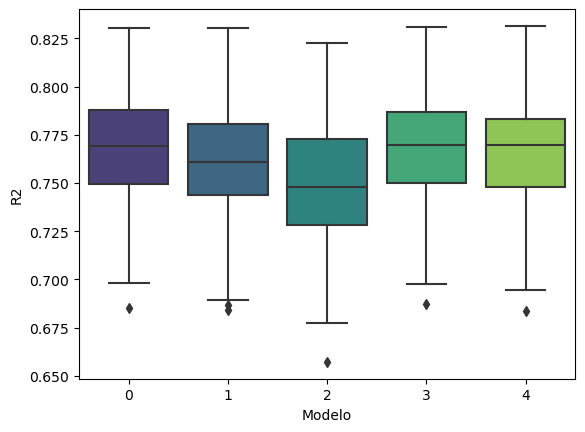

In [5]:
# Validación cruzada
form = 'fev ~ height + age + sex'
form2 = 'fev ~ height + age'
form3 = 'fev ~ height'
form4 = 'fev ~ height + age + sex + smoke'
form5 = 'fev ~ height + age + sex + smoke + aleatorio + aleatorio2'
list_form = [form,form2,form3,form4, form5]

list_res = pd.DataFrame(map(lambda x: nf.cross_val_lin(x,fev, seed=5764),list_form))

results = list_res.T.melt()
results.columns = ['Modelo','R2']
results.head()

# Boxplot sesgo-varianza
sns.boxplot(x='Modelo',y='R2',data=results,palette='viridis')

A la vista de los resultados. ¿Está sobreajustando tu modelo al conjunto de entrenamiento?

**Respuesta**:

Analizando los resultados, las diferencias son insignificantes, del orden de la milesima, por lo que podemos afirmar que NO hay sobreajuste en nuestro modelo.

## Pregunta 5

Indica el código necesario para leer el conjunto de datos **"IPI_Esp.xlsx"** y muestra su cabeza.

<Axes: >

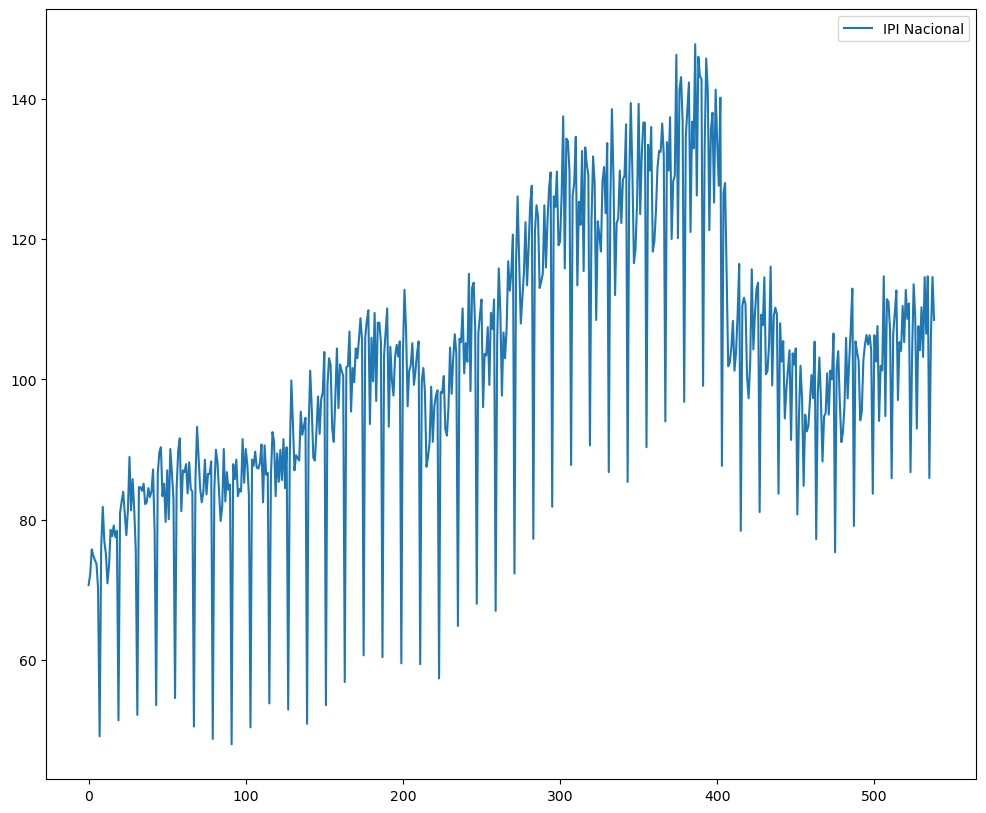

In [6]:
# Lectura de datos IPI
ipi = pd.read_excel('Datos/IPI_Esp.xlsx')

# Primeras filas
ipi.head()
plt.rcParams["figure.figsize"] = (12,10)
ipi.plot()

## Pregunta 6

Convierte el conjunto en una serie temporal legible para Python y representa gráficamente la evolución. 

In [7]:
# Conversión a serie temporal legible
ipi.Date = [str(i).replace('M', '-') for i in ipi.Date]
ipi.Date = pd.to_datetime(ipi.Date, format = 'ISO8601')

In [8]:
# Convertir en date-time
ipi = ipi.set_index('Date')

In [9]:
# Mostrar valores de serie
ipi.head()

IPI Nacional
Date                    
1975-01-01        70.658
1975-02-01        72.180
1975-03-01        75.732
1975-04-01        74.844
1975-05-01        74.210

<Axes: xlabel='Date'>

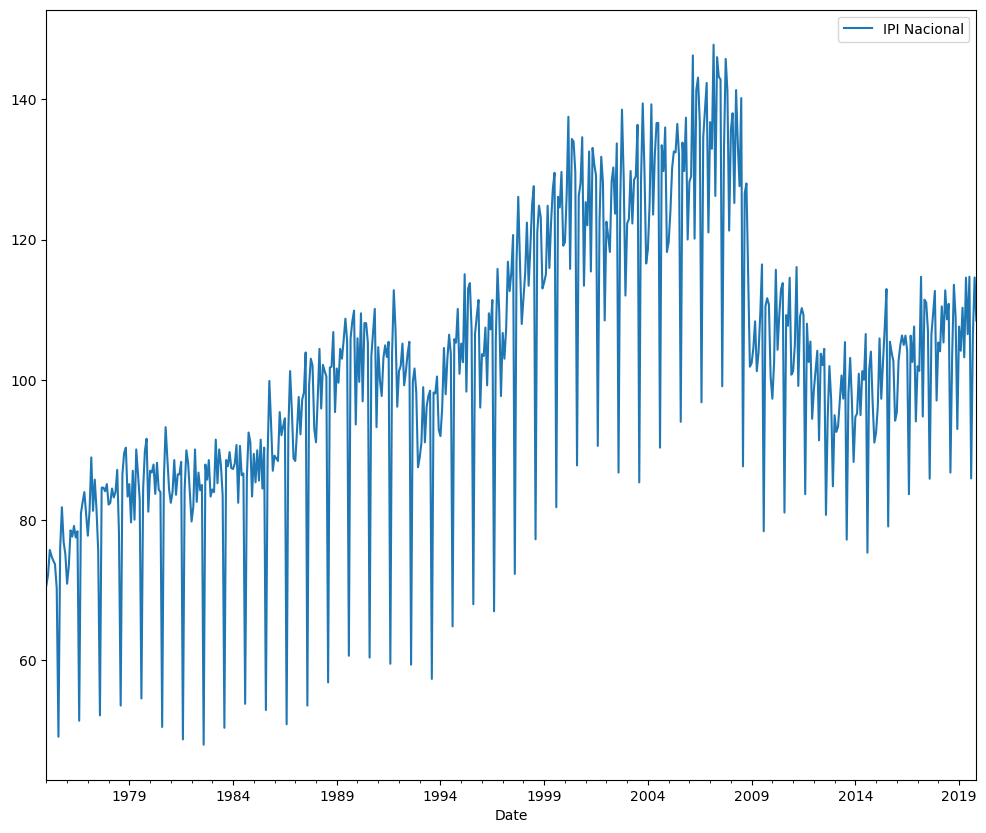

In [10]:
# Gráfico de evolución del IPI
plt.rcParams["figure.figsize"] = (12,10)
ipi.plot()

¿Qué componentes de la serie se pueden intuir en el gráfico?

**Respuesta**:

Podemos ver en el grafico anterior las componentes de tendencia, vemos como la grafica va creciendo a lo largo del tiempo, y estacionalidad, podemos observar oscilaciones periodicas.

## Pregunta 7

Toma una partición con ventana de entrenamiento (todo el histórico hasta diciembre de 2017) y prueba (2018 y 2019). Ajusta el modelo de suavizado que consideres más adecuado a la luz de las características de la serie. Evalua el modelo en términos de error y adecuación de los residuos. ¿El modelo satisface las condiciones residuales en cuanto a  autocorrelaciones?

/Users/juanarmariomunoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



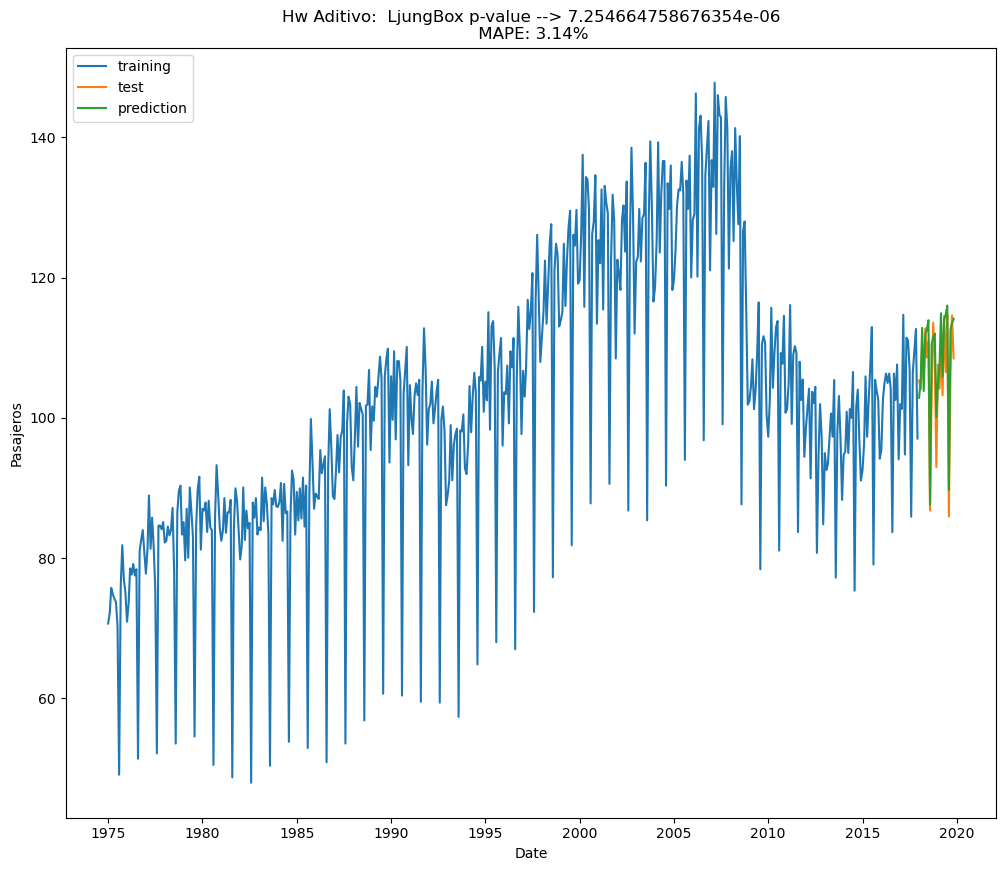

7.254664758676354e-06


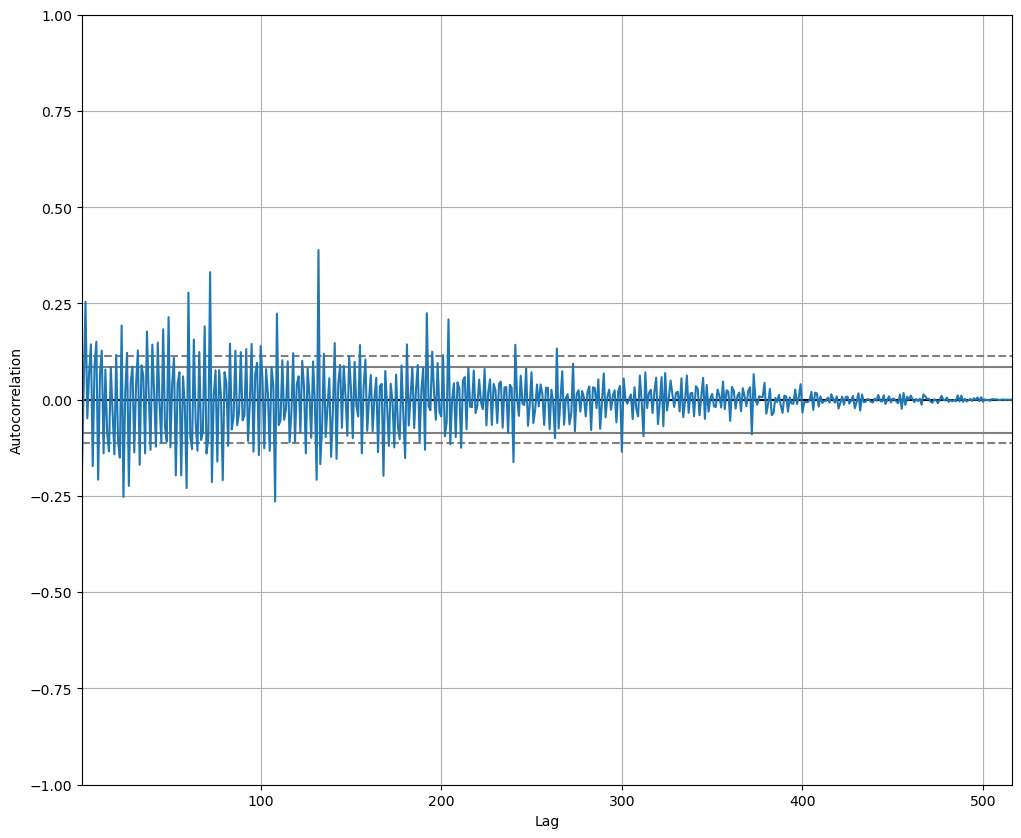

In [11]:
# Partición de datos
ipi_tr = ipi[:'2017-12-31']
ipi_tst = ipi['2018-01-01':]

ipi_tst

# Ajuste de modelo de suavizado
## ses = ets.SimpleExpSmoothing(ipi_tr).fit()
## ses.summary()
## nf.eval_model(ses,ipi_tr,ipi_tst,'SES')

## holt = ets.Holt(ipi_tr).fit()
## holt.summary()
## nf.eval_model(holt,ipi_tr,ipi_tst,'Holt')

hw_add = ets.ExponentialSmoothing(ipi_tr,trend='add', damped_trend=False, seasonal='add').fit()
hw_add.summary()
nf.eval_model(hw_add, ipi_tr, ipi_tst, 'Hw Aditivo')

# Evaluacion de los residuos
plt.clf()
autocorrelation_plot(hw_add.resid)
plt.show()

/Users/juanarmariomunoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/juanarmariomunoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning:

overflow encountered in matmul



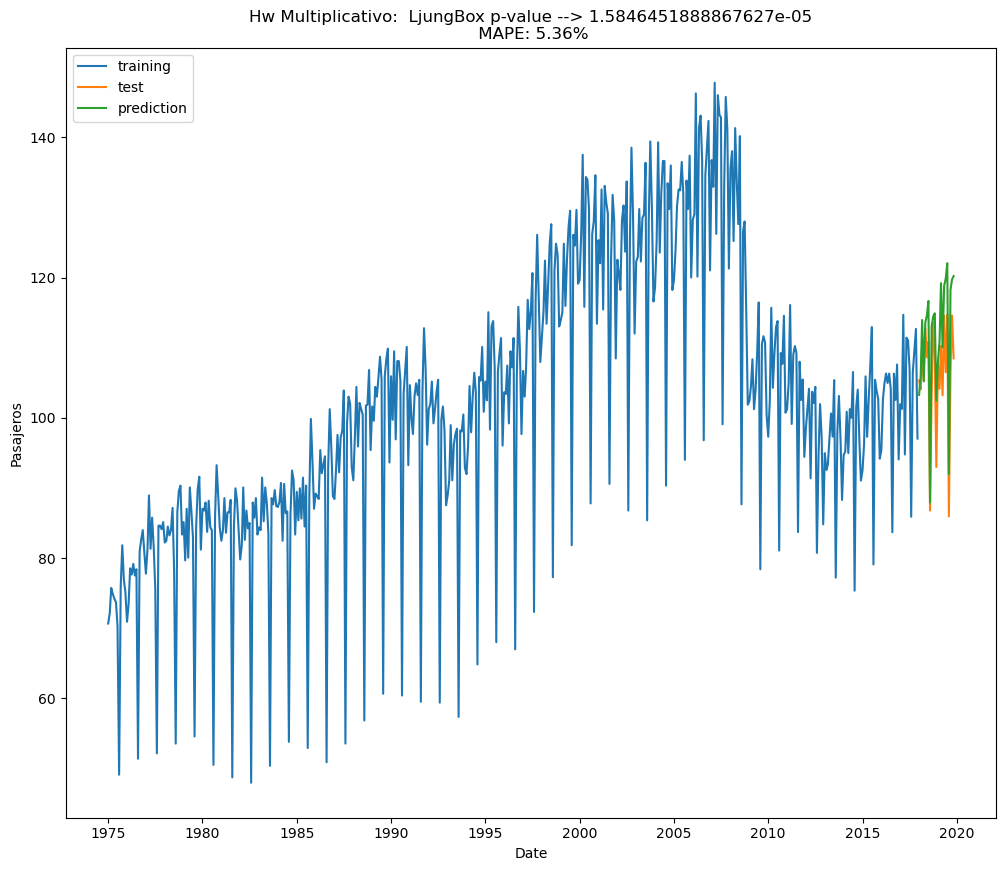

1.5846451888867627e-05


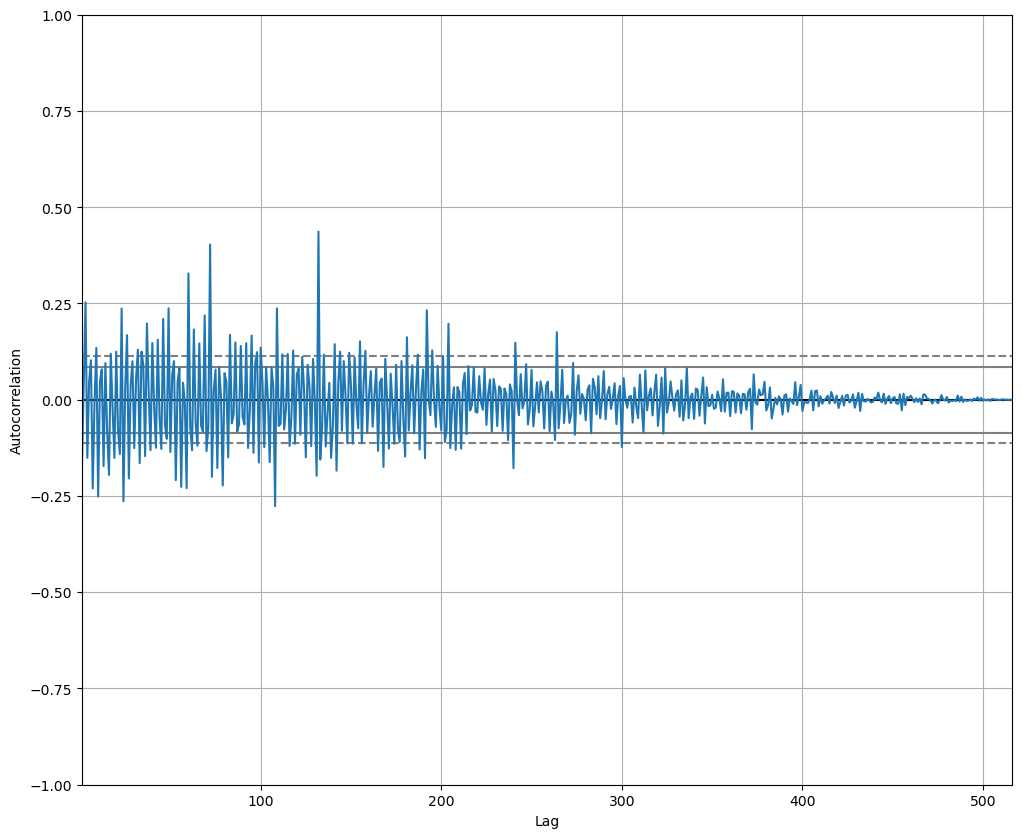

In [12]:
hw_mul = ets.ExponentialSmoothing(ipi_tr,trend='mul', damped_trend=False, seasonal='mul').fit()
hw_mul.summary()
nf.eval_model(hw_mul, ipi_tr, ipi_tst, 'Hw Multiplicativo')

# Evaluacion de los residuos
plt.clf()
autocorrelation_plot(hw_mul.resid)
plt.show()

**Respuesta**:

Tras haber aplicado el ajustado el modelo suavizado aplicando todos los metodos existentes, descarte lo que inicialmente predijimos, al existir tendencia y estacionalidad, el modelo ses y holt "simple" no serian buenos en terminos de error y correlacion de los residuos.

Tras ello aplique los modelos de holt aditivo y multiplicativo, y aunque el aditivo presenta un mejor resultado en terminos de error, ambos muestran unos resultados en cuanto a los residuos bastante alejados de lo que deseamos. Ninguno de los metodos satisface las condiciones de correlacion de los residuos.

## Pregunta 8

Presenta los correlogramas simple y parcial de la serie diferenciada en lo regular y estacional para el conjunto de entrenamiento. 

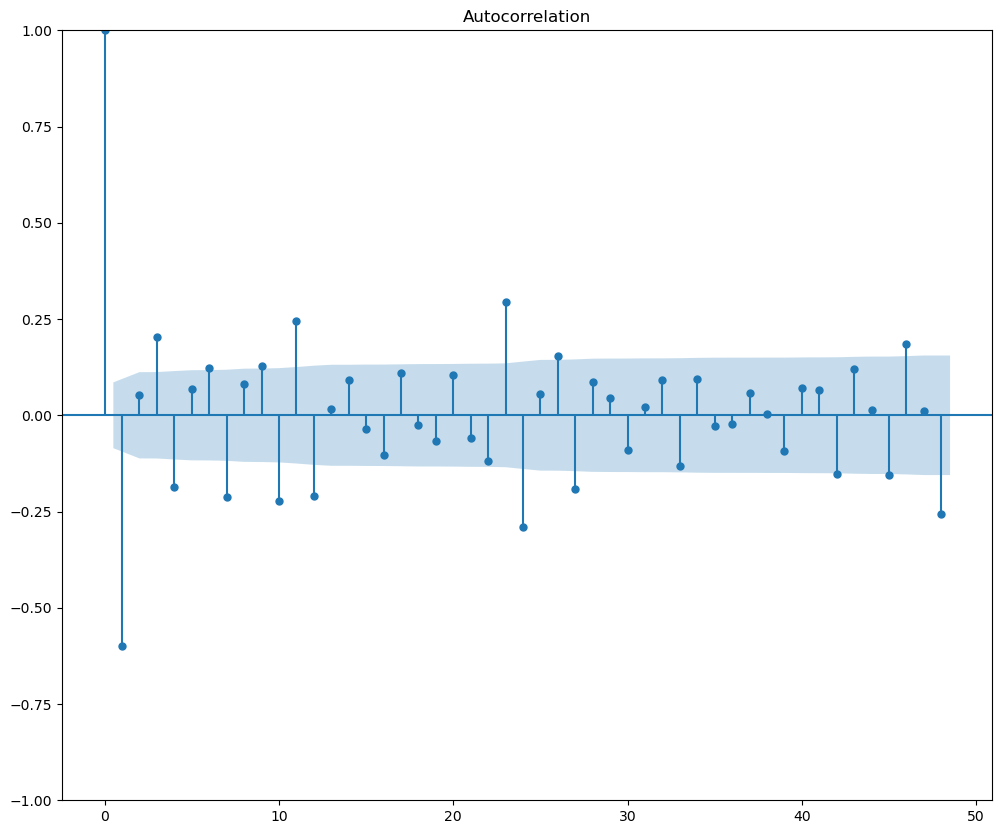

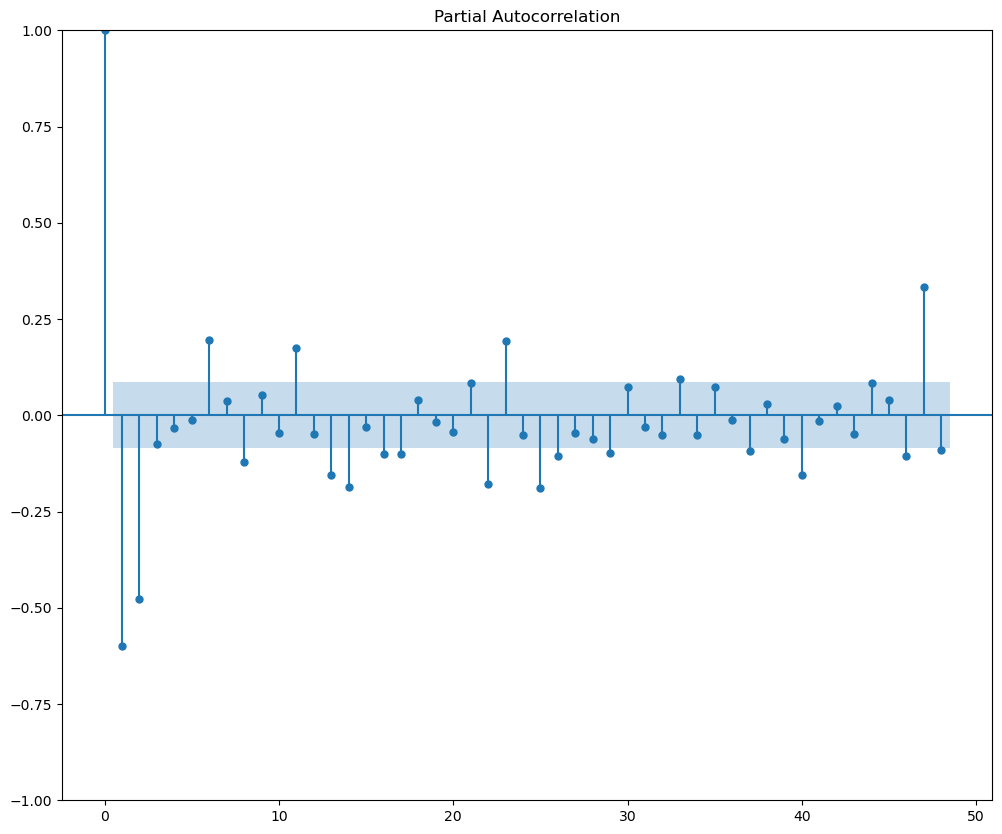

In [13]:
# Diferenciar serie
ipi_diff_1 = ipi.diff(periods=1)
## ipi_diff_1.plot()
## plt.show()

ipi_diff_1_12 = ipi_diff_1.diff(periods=12)
## ipi_diff_1_12.plot()
## plt.show()

# Correlograma simple ACF
plot_acf(ipi_diff_1_12.dropna(inplace=False),lags=48)
plt.show()

# Correlograma parcial PACF
plot_pacf(ipi_diff_1_12.dropna(inplace=False),lags=48,method='ywm')
plt.show()


A pesar de la dificultad, intentemos proponer algunos órdenes en lo regular y estcional para un tentativo modelo arima. 

¿Cual sería tu primer modelo a probar según lo que observas en la desaparición de las correlaciones con los retardos?

**Respuesta**: Mi modelo sería ARIMA(p,d,q)(P,D,Q)

Mi modelo seria ARIMA(1,1,1)(1,1,1) ya que tanto ACF como PACF inician con valores altos y caen a valores negativos tras el primer lag sin llegar a ser 0. 

## Pregunta 9

Ajusta ese modelo que propones y evalúa su capacidad de ajuste en test y la adecuación de residuos. 

In [14]:
# Ajuste de modelo ARIMA
arima_auto = pm.auto_arima(ipi_tr, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      #start_P=None, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=2989.952, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4372.087, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3610.070, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4370.092, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=3611.462, Time=0.35 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=3088.364, Time=0.57 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=2973.607, Time=1.74 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=3066.562, Time=0.84 sec
 ARIMA(1,1,1)(2,0,2)[12] intercept   : AIC=2950.128, Time=2.21 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=2958.683, Time=2.55 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=2978.941, Time=2.62 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=3046.169, Time=1.49 sec
 ARIMA(2,1,1)(2,0,2)[12] intercept   : AIC=2928.498, Time=2.69 sec
 ARIMA(2,1,1)(1,0,2)[12]

In [15]:
# Summary del modelo 
print(arima_auto.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  516
Model:             SARIMAX(2, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood               -1455.256
Date:                                 Wed, 03 Jul 2024   AIC                           2926.512
Time:                                         18:10:35   BIC                           2960.465
Sample:                                     01-01-1975   HQIC                          2939.818
                                          - 12-01-2017                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6535      0.088     -7.464      0.000      -0.825      -0

¿Son todos los efectos significativos en el modelo?

**Respuesta**: 

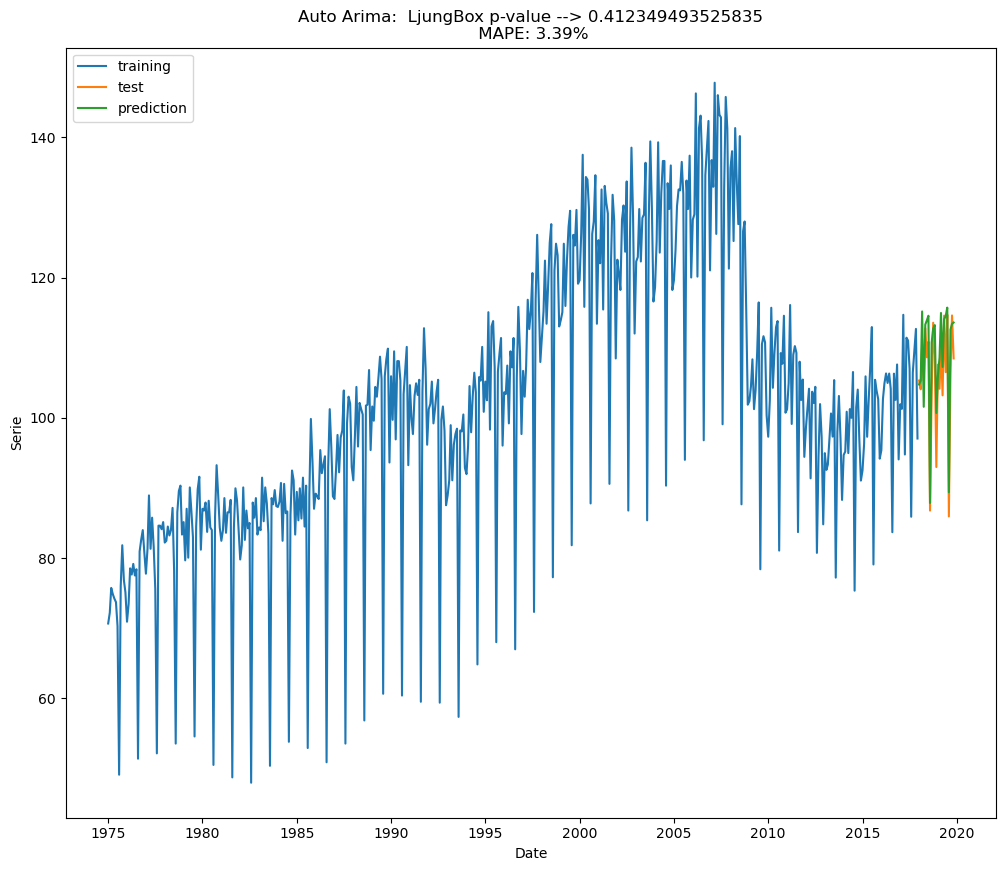

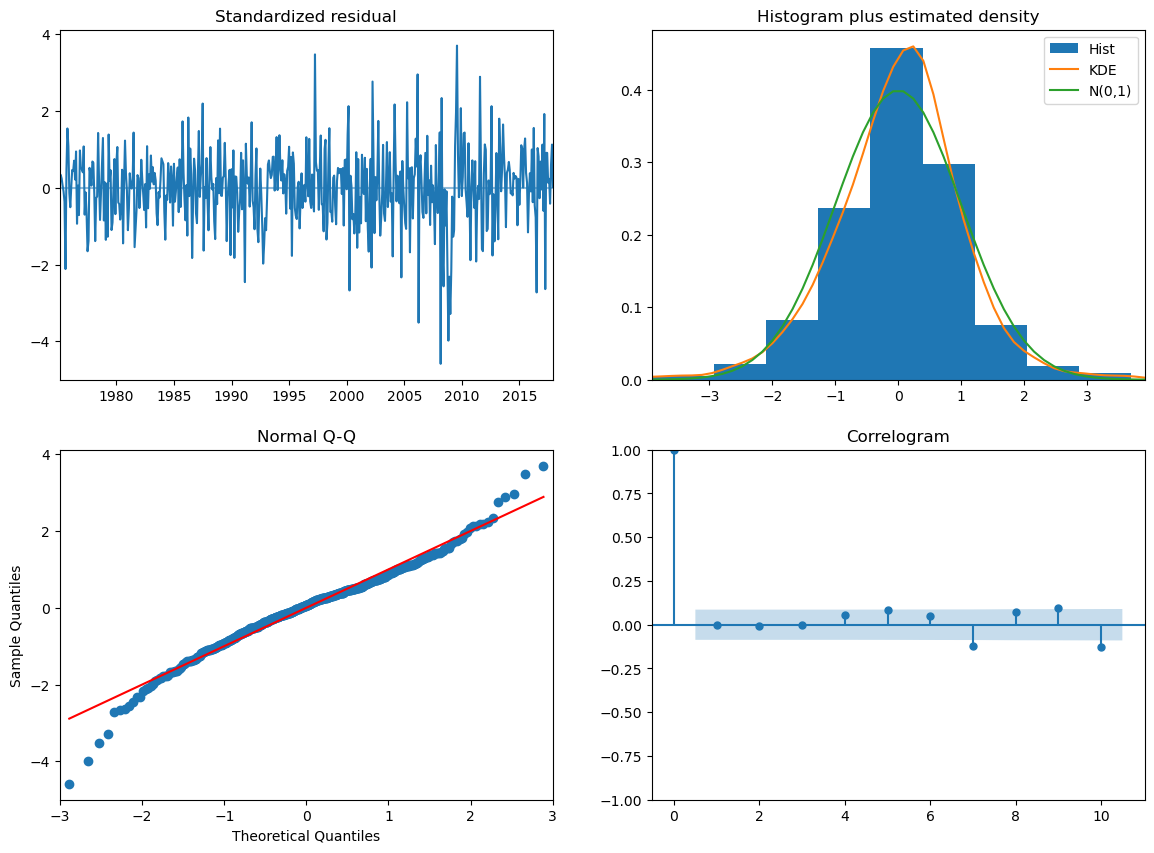

In [16]:
# Evaluación del modelo (eval_model)
nf.eval_model_Aarima(arima_auto,ipi_tr,ipi_tst,'Auto Arima')

¿Es tu modelo válido para la predicción en términos de adecuación residual? En caso contrario, juega con los órdenes para obtener un modelo que satisfaga el test de residuos. ¿Es este modelo aceptable mejor que el suavizado en términos de capacidad de predicción en el conjunto de test? 

**Respuesta**: 

El mejor modelo seria en mi caso, ARIMA(2,1,1)(2,0,2)[12]

Comparandolo con el modelo suavizado, si bien el coeficiente MAPE es similar, con el Auto Arima

## Pregunta 10

Indica el código necesario para leer el archivo **"clientes_cluster.csv"** y mostrar sus primeros registros. 

In [17]:
# Lectura clientes_cluster
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Lectura del archivo
clientes = pd.read_csv('Datos/clientes_cluster.csv')
clientes.head()

CustomerID  Gender   Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male  19.0                15.0                    39.0
1           2    Male  21.0                15.0                     NaN
2           3  Female  20.0                16.0                     6.0
3           4  Female  23.0                16.0                     NaN
4           5  Female  31.0                 NaN                    40.0

## Pregunta 11

Evalúa la incidencia de valores perdidos por variable e imputa el archivo mediante el método aleatorio, generando un nuevo archivo completo **"clientes_imputed"** del que se mostrará la información para comprobar que efectivamente todos los registros contienen valores válidos.

In [18]:
#Incidencia de missings por variable
clientes.apply(lambda x: x.isna().sum()/x.count()*100)

CustomerID                0.000000
Gender                    8.108108
Age                       6.951872
Annual Income (k$)        4.712042
Spending Score (1-100)    9.890110
dtype: float64

**Comentario**:

In [19]:
# Aleatoria: numéricas y nominales
imputer_rand = fe_imp.RandomSampleImputer()

# Imputación aleatoria
clientes_rand_imputed = imputer_rand.fit(clientes).transform(clientes)

# Info del archivo imputado
clientes_rand_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              200 non-null    int64  
 1   Gender                  200 non-null    object 
 2   Age                     200 non-null    float64
 3   Annual Income (k$)      200 non-null    float64
 4   Spending Score (1-100)  200 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 7.9+ KB


Recodifica *Gender* como una variable dummy (cualquier opción de código es bienvenida) en formato numérico y elimina el ID de cliente de cara al análisis.

In [20]:
# Recodificación de Gender como dummy
clientes_with_gender_Dummy = pd.get_dummies(clientes_rand_imputed, columns=['Gender'], drop_first=True)
clientes_without_ID = clientes_with_gender_Dummy.drop(['CustomerID'],axis=1)
clientes_without_ID.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     200 non-null    float64
 1   Annual Income (k$)      200 non-null    float64
 2   Spending Score (1-100)  200 non-null    float64
 3   Gender_Male             200 non-null    bool   
dtypes: bool(1), float64(3)
memory usage: 5.0 KB


## Pregunta 12

Explora los métodos de clustering jerárquico para formar grupos de clientes similares en cuanto a su comportamiento en estas 4 variables disponibles y presenta sus dendogramas. Si lo consideras necesario, escala los datos previamente.

ward :	0.01s


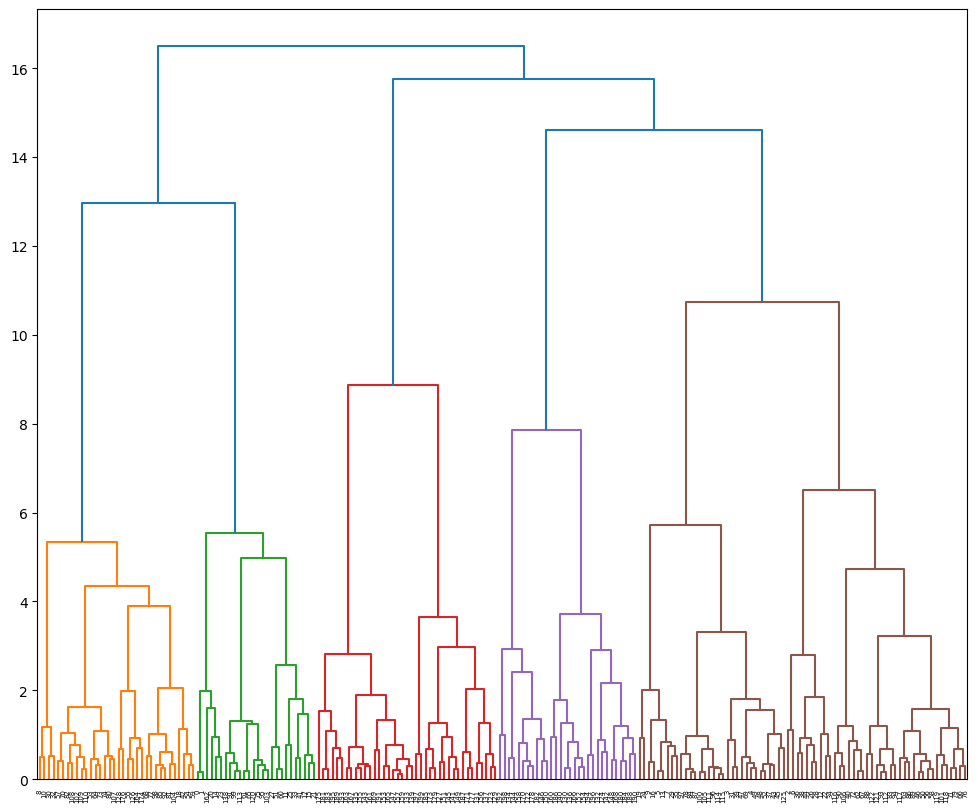

average :	0.00s


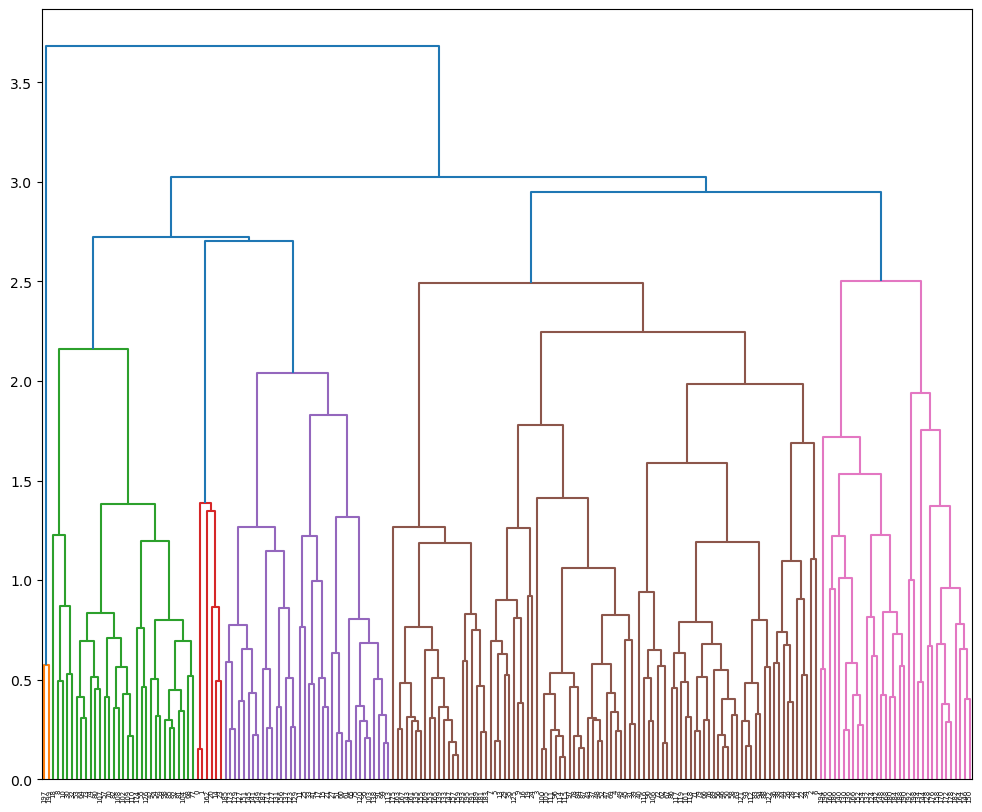

complete :	0.00s


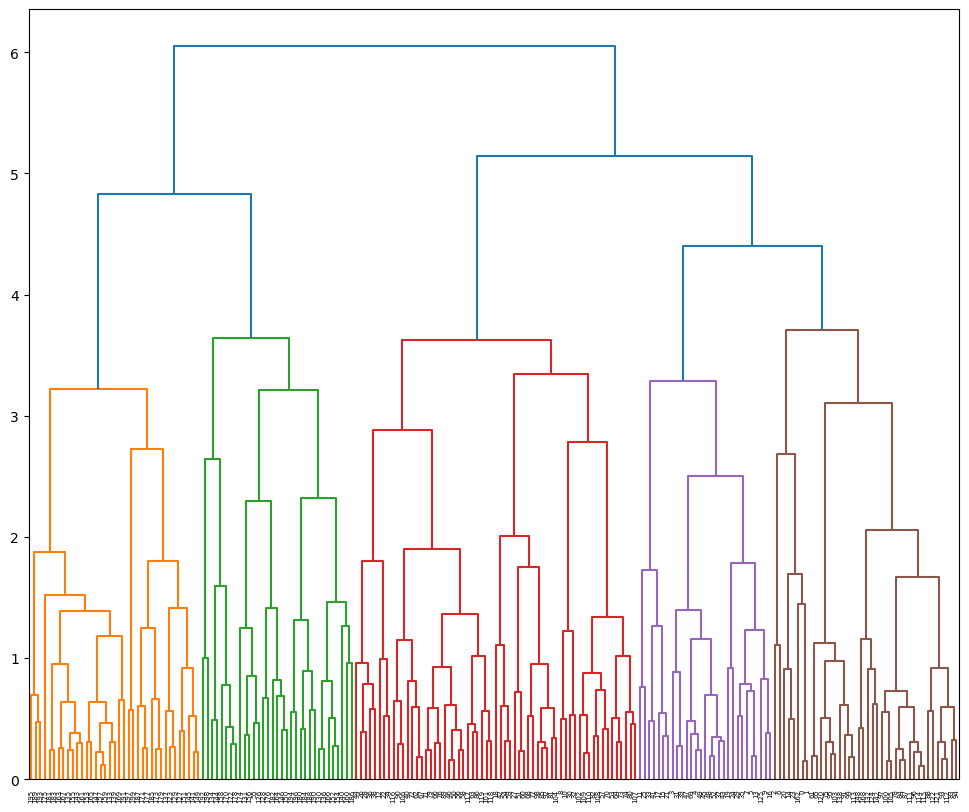

single :	0.01s


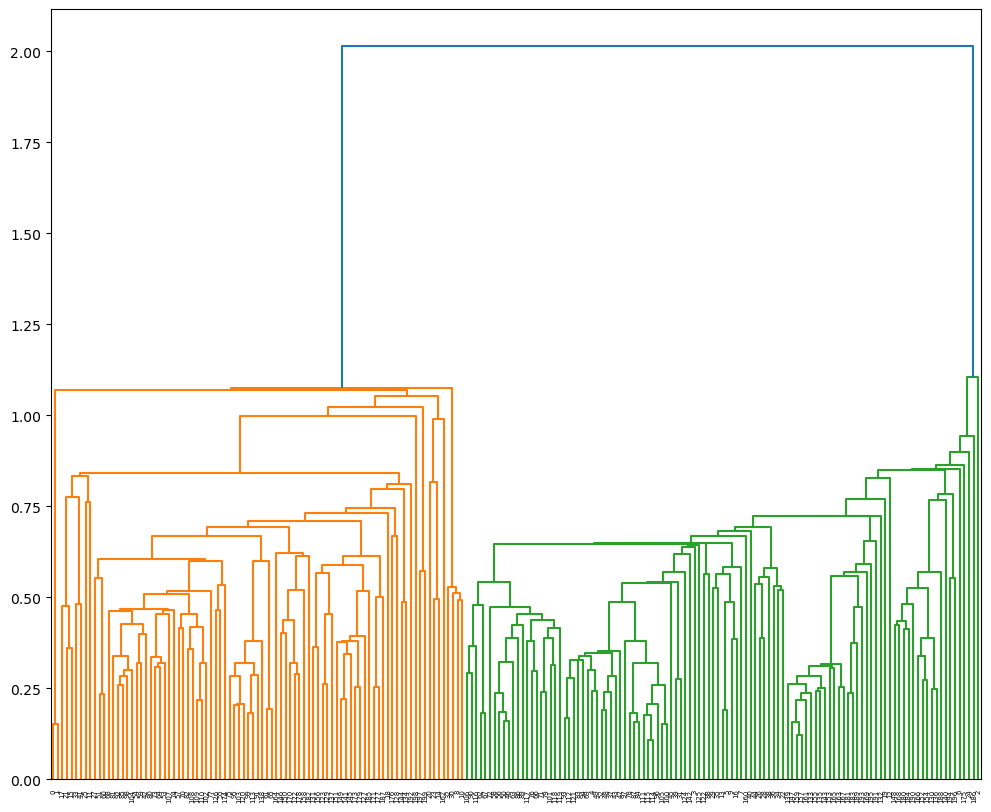

Opciones de 11 clusters
Silhouette: 0.3728471666292094
Calinski Harabasz Score: 71.01021873241399


Opciones de 12 clusters
Silhouette: 0.381650245739018
Calinski Harabasz Score: 71.7667983657918


In [21]:
# Clustering jerárquico bucle de dendogramas
clientes_scaled = scale(clientes_without_ID)

for linkage in ("ward", "average", "complete", "single"):
    np.random.seed(123456)  # for reproducibility
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=None,
                            distance_threshold = 0)
    t0 = time()
    clustering.fit(clientes_scaled)
    print("%s :\t%.2fs" % (linkage, time() - t0))
    
    plt.clf()
    nf.plot_dendogram(clustering)

## para 11 clusters    
modelo_hclust_ward11 = AgglomerativeClustering(
                            metric = 'euclidean',
                            linkage  = 'ward',
                            n_clusters  = 11
                     )
modelo_hclust_ward11.fit(X=clientes_scaled)
cluster_labels11 = modelo_hclust_ward11.fit_predict(clientes_scaled)

print('Opciones de 11 clusters')
print('Silhouette: ' + str(nf.silhouette_score(clientes_scaled, cluster_labels11)))
print('Calinski Harabasz Score: ' + str(metrics.calinski_harabasz_score(clientes_scaled, cluster_labels11)))
print('\n')

## para 12 clusters
modelo_hclust_ward12 = AgglomerativeClustering(
                            metric = 'euclidean',
                            linkage  = 'ward',
                            n_clusters  = 12
                     )
modelo_hclust_ward12.fit(X=clientes_scaled)
cluster_labels12 = modelo_hclust_ward12.fit_predict(clientes_scaled)

print('Opciones de 12 clusters')
print('Silhouette: ' + str(nf.silhouette_score(clientes_scaled, cluster_labels12)))
print('Calinski Harabasz Score: ' + str(metrics.calinski_harabasz_score(clientes_scaled, cluster_labels12)))

¿Cuál es el método de linkage más adecuado a la vista de los dendogramas? ¿Cuantos grupos de clientes formarías en base a las alturas del dendograma del linkage escogido?

**Respuesta**:

El metodo que recoge un mejor comportamiento i diferenciacion entre grupos seria el ward. Sin embargo no queda muy claro cuantos grupos podriamos formar, siendo las opciones de 11 y 12 las que inicialmente parecen mejores. Teniendo una silhouette muy parecidas me decantaria por la opcion de 11 clusters al tener mejor silhouette aunque solo sea una centesima mas alta, pero tendriamos un modelo mas simple.

## Pregunta 13

Explora el clustering K-means con distinto número de grupos y decide cuantos el número de clusters óptimo para la solución según este método. Comenta las métricas de evaluación.

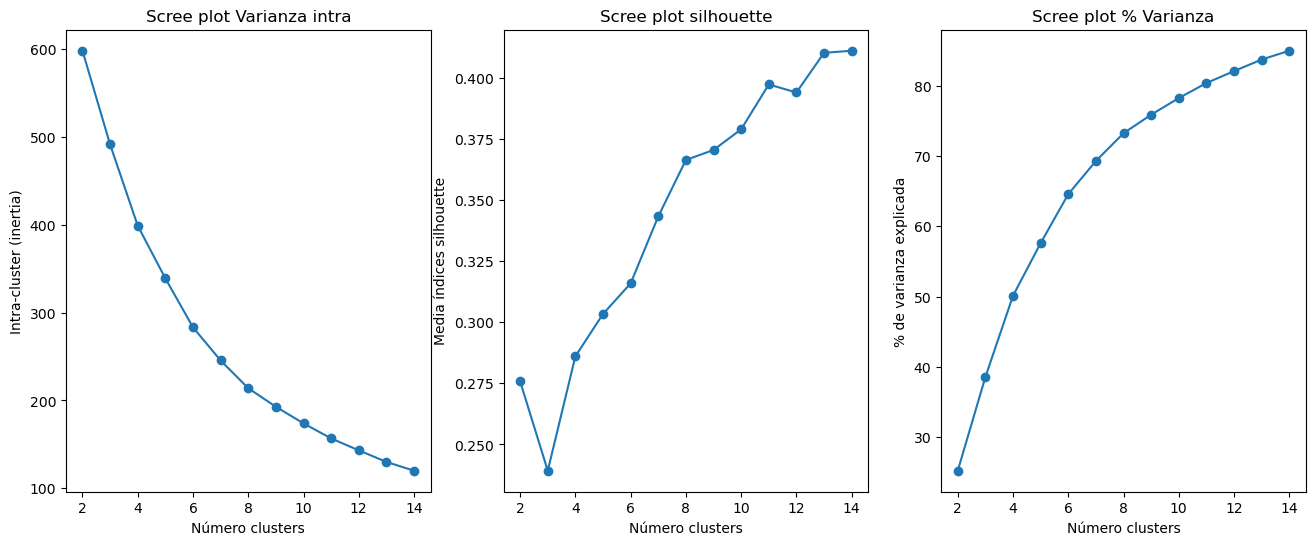

In [22]:
# Clustering k-means evaluación número clusters
nf.scree_plot_kmeans(clientes_without_ID,15)
plt.show()

**Respuesta**: 
Los resultados arrojados por las metricas obtenidas con el clustering k-means, indica que estabamos en lo cierto al dudar entre 11 y 12 grupos como solucion optima ya que vemos un pico en la grafica de silhouette en 12. Sin embargo obteniendo una explicacion del modelo de mas del 80% en ambos y una Silhouette bastante parecidas, me seguiria quedando con 11 grupos ya que mantendria el modelo algo mas simple.

Ajusta el clustering K-means con el núemero de grupos seleccionado y genera una nueva variable en el conjunto de datos imputado llamada *'Cluster'* que recoja el número de grupo asignado a cada registro. El tipo de la variable debe ser entero (int).  

In [23]:
# Ajuste de k-means
# Creación de variable cluster

cluster11 = nf.KMeans(n_clusters=11, n_init=25, random_state=123)
cluster11.fit(X = clientes_scaled)

print('Varianza intra: ' + str(cluster11.inertia_))

y_predict11 = cluster11.predict(X = clientes_scaled)
print('Silhouette: ' + str(nf.silhouette_score(clientes_scaled, y_predict11)))

total_incercia11 = np.sum(np.var(clientes_scaled, axis = 0) * clientes_scaled.shape[0])
print('Varianza explicada: ' + str(1 - (cluster11.inertia_ / total_incercia11)))

print('\n')

cluster12 = nf.KMeans(n_clusters=12, n_init=25, random_state=123)
cluster12.fit(X = clientes_scaled)

print('Varianza intra: ' + str(cluster12.inertia_))

y_predict12 = cluster12.predict(X = clientes_scaled)
print('Silhouette: ' + str(nf.silhouette_score(clientes_scaled, y_predict12)))

total_incercia12 = np.sum(np.var(clientes_scaled, axis = 0) * clientes_scaled.shape[0])
print('Varianza explicada: ' + str(1 - (cluster12.inertia_ / total_incercia12)))



Varianza intra: 156.77872637507306
Silhouette: 0.3971809764086857
Varianza explicada: 0.8040265920311587


Varianza intra: 143.19931489353112
Silhouette: 0.39390864433351863
Varianza explicada: 0.8210008563830861


Extrae los centroides de los grupos y comenta las principales características de cada grupo formado. 

In [24]:
# Centroides
print('Centroides')
print(cluster11.cluster_centers_)

print('Etiquetas')
cluster11.labels_[:5]

Centroides
[[-0.01900753  1.12996304 -1.49237483  1.11677706]
 [ 0.24121455 -1.23227913 -1.26968066 -0.89543386]
 [-0.4171527   1.00763629  1.24422842 -0.89543386]
 [ 0.97662478 -1.3750215  -1.53203149  1.11677706]
 [ 0.2550035   1.19352702 -1.15790946 -0.89543386]
 [-0.37979853  0.99828899  1.18471896  1.11677706]
 [-0.831061   -0.29950774 -0.06857283 -0.89543386]
 [ 1.17806324 -0.28858429 -0.03398681 -0.89543386]
 [ 1.22176152 -0.12670421 -0.13626395  1.11677706]
 [-0.69275643 -1.35005515  1.28451665 -0.89543386]
 [-1.03656072 -0.7551596   0.31817199  1.11677706]]
Etiquetas


array([10, 10,  1,  6,  6], dtype=int32)

**Comentarios**: 

## Pregunta 14

De cara a la proyección de los grupos formados en el espacio de características y dado que estamos en R4. Nos planteamos reducir la dimensionalidad a 2 para poder interpretar con mayor claridad mediante un bonito biplot. 

Para llevar a cabo esta tarea, necesitaremos ajustar un PCA con 2 dimensiones a los datos de entrada al clustering que hemos generado, es decir, tal vez utilizamos el conjunto de datos escalado si lo consideramos necesario. Mostraremos las cargas de las variables en las componentes y haremos una pequeña interpretación inicial de las 2 componentes.


In [25]:
# Ajuste PCA 2 dimensiones
pcaModel = pca(normalize=True,n_components=2)
results = pcaModel.fit_transform(clientes_without_ID.iloc[:,:4])

# Análisis de cargas
pcaModel.results['loadings']
pcaModel.results['PC']


[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


PC1       PC2
0   -0.182298 -0.923653
1   -0.109499 -0.911868
2    0.204305 -2.168887
3   -0.616814 -1.973751
4   -0.295138 -1.019558
5   -1.587909 -1.770921
6    0.943788 -2.056550
7   -2.027787 -1.643750
8    3.015670 -0.834345
9   -1.089740 -1.702404
10   2.868694 -0.767802
11  -1.019632 -0.436845
12   1.839638 -1.871355
13  -1.528241 -1.665345
14   1.394809 -0.841300
15  -1.133166 -0.551623
16  -0.903014 -1.612986
17  -0.886754 -0.593869
18   1.698462 -0.615400
19  -1.558946 -1.427008
20   0.684289 -0.609724
21  -0.839233 -0.447468
22   1.488820 -1.806320
23   0.992731 -0.689473
24  -0.731453 -1.304352
25  -0.600609 -0.242913
26   0.697731 -1.576969
27  -0.034329 -0.350931
28   0.363044 -1.546877
29  -1.687646 -1.322571
30   2.741025 -0.498581
31  -0.993585 -1.501548
32   2.378716 -0.428033
33  -1.740154 -0.091607
34   1.360758 -1.499954
35  -1.842655 -1.248301
36   0.926307 -1.476503
37  -0.696981 -1.320889
38   0.371189 -1.356342
39  -1.074108 -1.286022
40   1.570711 -1.182487
41  -1.462745  0.084636
42   1.240137 -0.092454
43  -0.830779 -1.130387
44   0.956975 -1.240359
45  -1.287819 -1.133056
46   0.274405 -1.066894
47  -0.657165 -1.184417
48  -0.773126 -1.136626
49  -0.322807 -1.196854
50   0.296665 -1.023118
51  -0.168409  0.074978
52  -0.659527 -1.041337
53   1.124158  0.192577
54   1.029819  0.082215
55   0.884716  1.149235
56   0.441607 -0.964236
57   1.996125  0.185035
58   0.555535 -0.886603
59   1.189252  0.194433
60  -0.028172  0.182779
61  -0.749443  0.127826
62   1.172663 -0.807028
63   0.335432 -0.814189
64   1.544493  0.315886
65  -0.915943  0.207608
66   0.025039 -0.865746
67   1.326032 -0.793018
68   0.281236  0.287303
69  -0.442771 -0.917703
70   1.781430  0.390968
71   0.435918 -0.862349
72   0.891252 -0.751911
73   1.251263  0.394170
74   1.615324  0.433605
75  -0.408317  0.396038
76   0.017644 -0.656090
77   0.451831  0.411664
78  -1.052804 -0.734287
79   0.513797 -0.699389
80   1.218935  0.483545
81   0.612248  0.470914
82   1.987417  0.465314
83  -0.238489 -0.735589
84  -1.287398 -0.715209
85   0.904822  0.427941
86   0.368508 -0.503374
87  -1.196716 -0.628385
88  -0.737332 -0.531555
89   0.547737 -1.332034
90   1.089122 -0.413110
91  -0.478708  0.458924
92   0.797662  0.630956
93   0.092523 -0.551978
94  -0.360468 -0.568256
95  -0.480414  0.566692
96  -1.143769 -0.585705
97  -0.825606 -0.543709
98   0.982045  0.626213
99  -0.603424  0.569243
100 -0.791199 -0.540757
101  0.316985 -0.418415
102  1.467017  0.808012
103 -0.470301  0.651293
104  0.650030  0.732810
105 -0.917929 -0.542254
106  1.106677 -0.320414
107  1.164722  0.729240
108  1.943974  0.760297
109  1.559733  0.769412
110  1.551635  0.796628
111 -1.345660 -0.455907
112 -0.061173 -0.548332
113 -0.585540  0.644283
114 -1.242503 -0.427562
115 -1.246552 -0.413954
116  1.137036 -0.303854
117  0.055379 -0.611945
118  0.529692 -0.281173
119  0.102289 -0.212482
120 -0.469270  0.816076
121 -0.037882 -0.339772
122 -0.423501 -0.240544
123 -0.229990  0.985319
124 -0.502627 -0.352371
125 -1.266608 -1.016823
126  0.877621  0.886243
127 -0.889971  1.184905
128  2.322918  0.815923
129 -0.450421  1.075389
130  1.229489 -0.344287
131  0.138776  0.975835
132 -0.638366  0.399058
133 -1.244883 -0.047242
134  0.530543  0.718085
135 -1.807443  0.064824
136  1.125019 -0.302008
137 -0.704538  1.107706
138 -0.629312  0.956921
139 -1.081074  0.033712
140  1.818668 -0.206600
141 -1.252608  1.273108
142 -0.576101 -0.091603
143 -1.643961  0.163434
144  0.573686  0.895750
145 -1.568755  1.342928
146  1.694016  0.977267
147 -1.297784  0.127829
148  0.199822 -0.101739
149 -1.085077  1.358110
150  1.332364  1.012503
151 -0.781733  1.364425
152  0.752578 -0.078821
153 -1.056798  0.189304
154  1.010088 -0.089434
155 -1.956059  0.219646
156  0.143200  1.162322
157 -1.509789  0.173027
158  1.314874  0.900318
159 -1.428892  0.157596
160  0.942304  0.069446
161 -1.698877  0.226689
162  0.699519 -0.848429
163 -1.877524  0.347295
164  1.408209  1.300888
165 -1.160237  0.396366
16

**Interpretación inicial**:

Ahora generamos y mostramos el biplot para interpretar con mayor seguridad las componentes. 

[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


[scatterd] >INFO> Create scatterplot


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '2 Principal Components explain [58.20%] of the variance'}, xlabel='PC1 (32.7% expl.var)', ylabel='PC2 (25.4% expl.var)'>)

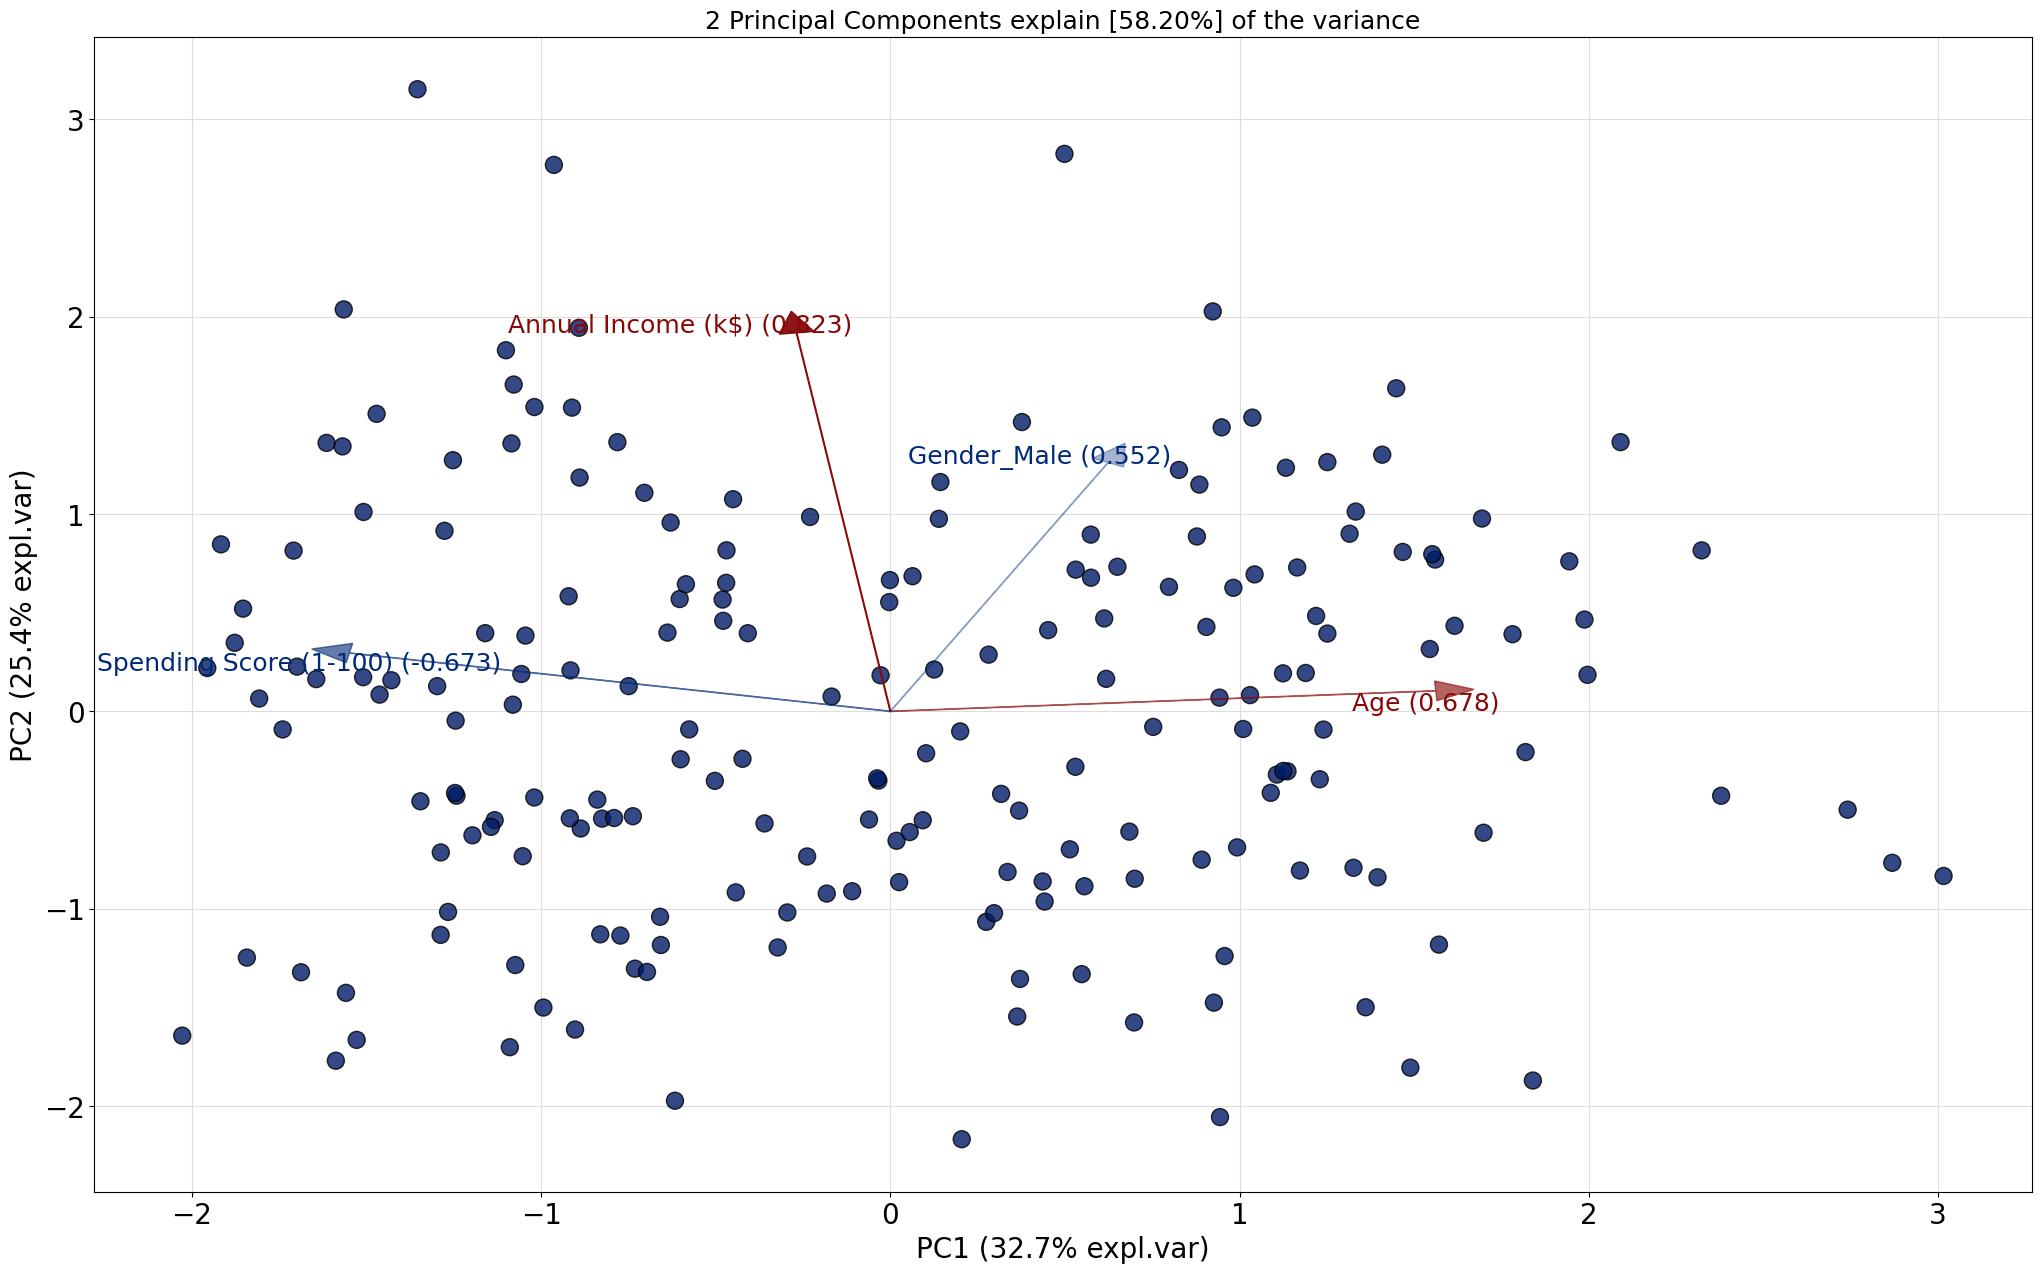

In [26]:
# Biplot
pcaModel.biplot(legend=False)


**Interpretación gráfica**:

Ahora que sabemos lo que represanta cada componente en el espacio original de las variables, necesitamos un conjunto de datos que contenga las columnas *PC1*,*PC2* y *Cluster* para realizar la representación de los clientes por grupos propuestos e interpretar las características de los grupos en el espacio de las componentes. 

In [27]:
# Creación dataset dimensión reducida
clientes_with_cluster_kmeans = clientes_without_ID.copy()

cluster_labels11 = cluster11

clientes_with_cluster_kmeans['cluster_kmeans'] = cluster_labels11

clientes_pca = pcaModel.results['PC'].join(clientes_with_cluster_kmeans['cluster_kmeans'])
clientes_pca

# Representación de grupos en espacio de componentes
fig = px.scatter(clientes_pca, x='PC1',y='PC2', color='cluster_kmeans', text=clientes_pca.index)
fig.update_layout(height=800)
fig.show()


**Interpretación de biplot**: